# Import python packages

In [1]:
import os
SRC_PATH = '../src/'
os.chdir(SRC_PATH)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

SEED = 7
np.random.seed(SEED)

# Define parameters and load dataset

In [21]:
ATTENTION_NAME = 'SDPA_QS_KS' # choose between 'SDPA' - the regular, 'SASA', and 'SDPA_QS_KS'
LABELS = 'geo' # choose between 'geo', 'owner', 'vf and 'combined'
DATA_TYPE = 'countries' # choose between 'lats_longs' and 'countries'

In [4]:
MODEL_NAME = DATA_TYPE + '_' + LABELS + '_classification_' + ATTENTION_NAME + '_SimpleNet'

ipsource_dict = {1: 'M', 2: 'R', 3: 'A', 4: 'X', 0: "pad"}
SOURCES_NUM = len(ipsource_dict) + 1
label_dict = {0: 'G', 1: 'R',2: 'Unknown'}
class_names = ["GREEN", "RED"]

DATA_PATH = '../data/'
MODELS_PATH = '../models/'
RESULTS_PATH = '../results/'

path_prefix = RESULTS_PATH + MODEL_NAME

training = pd.read_pickle("../data/dataset_b_noisy_7_agents_training.pkl") 
test_comb = pd.read_pickle("../data/dataset_b_noisy_7_agents_test.pkl") 
print(len(training), len(test_comb))

2802801 702383


In [5]:
training.head()

,srcAS,destAS,srcCC,destCC,num_hops,lat,long,IPsource,geoCC,ASN,vf,combined,geo,owner
trid,,,,,,,,,,,,,,
1328731,14061,42999,US,TR,10,"[50.115520000000004, 50.115520000000004, 50.11...","[8.68417, 8.68417, 8.68417, 8.67185, 9.491, 8....","[1, 2, 1, 1, 3, 1, 3, 3, 2, 3]","[DE, DE, DE, DE, DE, DE, TR, TR, TR, TR]","[14061, 14061, 2914, 2914, 2914, 9121, 9121, 9...",0,0,0,0
5183622,138062,3605,ID,GU,1,[22.285521],[114.1577],[1],[HK],[24482],0,0,0,0
3258755,14061,24173,US,VN,10,"[40.714271999999994, 40.714271999999994, 40.71...","[-74.005966, -74.005966, -74.005997, -122.3320...","[1, 1, 1, 1, 1, 1, 1, 3, 3, 3]","[US, US, US, US, JP, HK, HK, HK, VN, VN]","[14061, 14061, 2914, 2914, 2914, 2914, 2914, 2...",0,0,0,0
2660757,16276,7171,FR,US,13,"[0.0, 0.0, 0.0, 0.0, 1.28967, 43.296669, 48.86...","[0.0, 0.0, 0.0, 0.0, 103.850098, 5.37639, 2.34...","[4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[nan, nan, nan, nan, SG, FR, FR, FR, FR, US, U...","[0, 0, 0, 0, 16276, 16276, 16276, 6461, 6461, ...",0,0,0,0
1730541,20473,12479,US,ES,7,"[48.860001000000004, 48.860001000000004, 48.86...","[2.34444, 2.34444, 2.34444, 5.381069999999999,...","[1, 1, 1, 2, 1, 1, 1]","[FR, FR, FR, FR, ES, ES, ES]","[3257, 3257, 3257, 5511, 5511, 5511, 5511]",0,0,0,0


In [6]:
print(training[LABELS].value_counts())
print(training[LABELS].value_counts(normalize=True))

0    2710641
1      86408
2       5752
Name: geo, dtype: int64
0    0.967119
1    0.030829
2    0.002052
Name: geo, dtype: float64


In [7]:
print(test_comb[LABELS].value_counts())
print(test_comb[LABELS].value_counts(normalize=True))

0    679078
1     21788
2      1517
Name: geo, dtype: int64
0    0.96682
1    0.03102
2    0.00216
Name: geo, dtype: float64


In [8]:
max_len = max(len(raw) for raw in training['lat'].values)
max_len = max(max_len, 40)
print(max_len)

40


## Process data

In [9]:
from data_utils import *

training = generate_dataset_and_meta(training, data_type=DATA_TYPE, max_len=max_len)
print(len(training))

test_comb = generate_dataset_and_meta(test_comb, data_type=DATA_TYPE, max_len=max_len)
print(len(test_comb))

Using TensorFlow backend.
C:\Users\tals\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tals\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tals\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tals\AppData\Roaming

2802801
702383


In [10]:
training.head()

,srcAS,destAS,srcCC,destCC,num_hops,lat,long,geoCC,ASN,vf,combined,geo,owner,sources,countries
trid,,,,,,,,,,,,,,,
1328731,14061,42999,US,TR,10,"[50.115520000000004, 50.115520000000004, 50.11...","[8.68417, 8.68417, 8.68417, 8.67185, 9.491, 8....","[DE, DE, DE, DE, DE, DE, TR, TR, TR, TR]","[14061, 14061, 2914, 2914, 2914, 9121, 9121, 9...",0,0,0,0,"[1, 2, 1, 1, 3, 1, 3, 3, 2, 3, 0, 0, 0, 0, 0, ...","[DE, DE, DE, DE, DE, DE, TR, TR, TR, TR, , , ,..."
5183622,138062,3605,ID,GU,1,[22.285521],[114.1577],[HK],[24482],0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[HK, , , , , , , , , , , , , , , , , , , , , ,..."
3258755,14061,24173,US,VN,10,"[40.714271999999994, 40.714271999999994, 40.71...","[-74.005966, -74.005966, -74.005997, -122.3320...","[US, US, US, US, JP, HK, HK, HK, VN, VN]","[14061, 14061, 2914, 2914, 2914, 2914, 2914, 2...",0,0,0,0,"[1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 0, 0, 0, 0, 0, ...","[US, US, US, US, JP, HK, HK, HK, VN, VN, , , ,..."
2660757,16276,7171,FR,US,13,"[0.0, 0.0, 0.0, 0.0, 1.28967, 43.296669, 48.86...","[0.0, 0.0, 0.0, 0.0, 103.850098, 5.37639, 2.34...","[nan, nan, nan, nan, SG, FR, FR, FR, FR, US, U...","[0, 0, 0, 0, 16276, 16276, 16276, 6461, 6461, ...",0,0,0,0,"[4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[-, -, -, -, SG, FR, FR, FR, FR, US, US, US, U..."
1730541,20473,12479,US,ES,7,"[48.860001000000004, 48.860001000000004, 48.86...","[2.34444, 2.34444, 2.34444, 5.381069999999999,...","[FR, FR, FR, FR, ES, ES, ES]","[3257, 3257, 3257, 5511, 5511, 5511, 5511]",0,0,0,0,"[1, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[FR, FR, FR, FR, ES, ES, ES, , , , , , , , , ,..."


# Map Countries & Define Embedding Parameters

In [47]:
import pickle
import os.path

if DATA_TYPE == "countries":
    
    if os.path.isfile(DATA_PATH + 'country_idx.pkl'):
        country_idx = pickle.load(open(DATA_PATH + 'country_idx.pkl', 'rb'))
        total_countries = len(country_idx)
        print(total_countries)
    else:
        country_idx = dict()
        country_idx["-"] = 0
        country_idx[""] = 1
        idx = 1

        for route in training[DATA_TYPE]:
            for country in route:
                if country not in country_idx:
                    idx += 1
                    country_idx[country] = idx
        total_countries = idx + 1
        print(total_countries)
        pickle.dump(country_idx, open(DATA_PATH + 'country_idx.pkl', 'wb'))
    embedding_vecor_length = 32
else:
    total_countries = None
    country_idx = None
    embedding_vecor_length = 32

240


# Generate training and test sets

In [12]:
if DATA_TYPE == "lats_longs":
    input_shape = np.array(training["lats_longs"].values[0]).shape
else:
    input_shape = np.array(training["countries"].values[0]).shape
print(input_shape)

(40,)


## Create np arrays

### Remove UNDECIDED by chosen label

In [13]:
print(len(test_comb))

test = test_comb[test_comb[LABELS] < 2]
print(len(test))

training = training[training[LABELS] < 2]
print(len(training))

702383
700866
2797049


### Generate np arrays for test_comb (evaluation on the 'label_comb'), training and test sets

In [14]:
x_test_comb, u_test_comb, y_test_comb = generate_set_arrays(test_comb, max_len, DATA_TYPE, 'combined', country_idx)
print(x_test_comb.shape, u_test_comb.shape, y_test_comb.shape)

(702383, 40) (702383, 40) (702383,)


In [15]:
x_training, u_training, y_training = generate_set_arrays(training, max_len, DATA_TYPE, LABELS, country_idx)
print(x_training.shape, u_training.shape, y_training.shape)

(2797049, 40) (2797049, 40) (2797049,)


In [16]:
x_test, u_test, y_test = generate_set_arrays(test, max_len, DATA_TYPE, LABELS, country_idx)
print(x_test.shape, u_test.shape, y_test.shape)

(700866, 40) (700866, 40) (700866,)


In [17]:
print(np.unique(u_test))

[0 1 2 3 4]


# Define and run Attention model

## Define Model

In [22]:
from attention_models import generate_model, ATTENTION_NAME_TYPE_DICT

print("Supported attention layers:", list(ATTENTION_NAME_TYPE_DICT.keys()))

Supported attention layers: ['SDPA', 'SDPA_Q_S', 'SASA', 'SDPA_QS_KS', 'SDPA_Mul_S']


In [23]:
if DATA_TYPE == "lats_longs":
    USE_EMBEDDING = False
else:
    USE_EMBEDDING = True

if ATTENTION_NAME == "SDPA":
    USE_SOURCES = False
else:
    USE_SOURCES = True

ATTENTION_FIRST = True
BLSTM = True
NO_LSTM = False


model = generate_model(input_shape, ATTENTION_NAME, USE_SOURCES, USE_EMBEDDING, num_categories=total_countries,
                       embedding_vecor_length=embedding_vecor_length, attention_first=ATTENTION_FIRST,
                       blstm=BLSTM, no_lstm=NO_LSTM)
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedded_sources (Embedding)    (None, 40, 1)        5           input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 32)       7680        input_1[0][0]                    
_____________________________________

## Define training params

In [24]:
from sklearn.utils import class_weight
import math

BALANCED_GENERATOR = True
EPOCH_IS_ENTIRE_DATA = False
epochs = 1 ##60 
batch_size = 64

samples_per_epoch = 1024 #128 * 1024
if EPOCH_IS_ENTIRE_DATA:
    samples_per_epoch = math.ceil(len(x_training)/batch_size)

val_batch_size = 1024
validation_steps = math.ceil(len(x_test)/val_batch_size)

CLASS_WEIGHTS = False
class_weights = None
if CLASS_WEIGHTS:
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(training[LABELS]),
                                                 training[LABELS])
print(class_weights)

None


In [25]:
from keras.callbacks import TensorBoard,ModelCheckpoint

# tensorboard = TensorBoard(log_dir=MODELS_PATH + MODEL_NAME + '_Graph', histogram_freq=1, write_grads=True, write_graph=True,
#                           write_images=True, batch_size=batch_size)
# tensorboard.set_model(model)

checkpointer_acc = ModelCheckpoint(monitor='val_acc', filepath= MODELS_PATH + MODEL_NAME + '_acc.hdf5', verbose=1, save_best_only=True, save_weights_only=True)

callbacks = [checkpointer_acc] #tensorboard


## Fit with Balanced Generator for regular attention (SDPA)

In [26]:
from training_utils import balanced_generator, val_generator, generator

def regular_training():
    if BALANCED_GENERATOR:
            training_generator = balanced_generator(x_training, y_training, batch_size=batch_size, input_shape=input_shape, 
                                                    use_embedding=USE_EMBEDDING, random_state=SEED)
    elif EPOCH_IS_ENTIRE_DATA:
        training_generator = val_generator(x_training, y_training, batch_size)
    else:
        training_generator = generator(x_training, y_training, batch_size=batch_size)

    return model.fit_generator(generator=training_generator, epochs=epochs, class_weight=class_weights,
                                  steps_per_epoch=samples_per_epoch, verbose=1, callbacks=callbacks,
                                  validation_data=val_generator(x_test, y_test,val_batch_size), validation_steps=validation_steps)

if not USE_SOURCES:
    history = regular_training()
        

## Fit with balanced generator for attention with sources

In [27]:
from training_utils import balanced_sources_generator, val_sources_generator, sources_generator

def sources_training():
    if BALANCED_GENERATOR:
        training_generator = balanced_sources_generator(x_training, u_training, y_training, batch_size=batch_size, 
                                                        input_shape=input_shape, use_embedding=USE_EMBEDDING, random_state=SEED)
    elif EPOCH_IS_ENTIRE_DATA:
        training_generator = val_sources_generator(x_training, u_training, y_training, batch_size)
    else:
        training_generator = sources_generator(x_training, u_training, y_training, batch_size)

    return model.fit_generator(generator=training_generator, epochs=epochs, class_weight=class_weights,
                                  steps_per_epoch=samples_per_epoch, verbose=1, callbacks=callbacks,
                                  validation_data=val_sources_generator(x_test, u_test, y_test,val_batch_size), validation_steps=validation_steps)

if USE_SOURCES:
    history = sources_training()
        

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1024/1024 [==============================] - 446s 435ms/step - loss: 0.5044 - acc: 0.7409 - val_loss: 0.3065 - val_acc: 0.8762

Epoch 00001: val_acc improved from -inf to 0.87624, saving model to ../models/countries_geo_classification_SDPA_QS_KS_SimpleNet_acc.hdf5


# Plot history accuracy

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


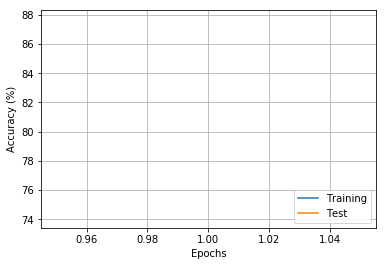

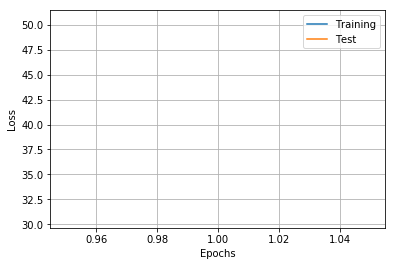

In [28]:
from evaluation_utils import *
import pickle

with open(RESULTS_PATH + MODEL_NAME +  "_accuracy.pkl", 'wb') as output:
    pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)

#list all data in history
print(history.history.keys())
plot_history_accuracy(history.history, epochs, RESULTS_PATH + MODEL_NAME)
plot_history_loss(history.history, epochs, RESULTS_PATH + MODEL_NAME)

# Final evaluation of the model
## Load best checkpoint

In [29]:
model.load_weights(MODELS_PATH + MODEL_NAME + '_acc.hdf5')

## Evaluate accuracy over the test set

In [30]:
from model_utils import *

y_test_prediction, y_test_prob = get_model_pred_prob(model, x_test, u_test, val_batch_size, USE_SOURCES)
print(len(y_test_prediction), len(y_test))

700866/700866 [==============================] - 277s 395us/step
700866 700866


In [31]:
print_evaluation_metrics(y_test, y_test_prediction, y_test_prob, ATTENTION_NAME)

accuracy_score for SDPA_QS_KS 0.8762416781524571
FA for SDPA_QS_KS 0.11643875961229788
Detection rate i.e. recall_score for SDPA_QS_KS 0.648109050853681
AUC for SDPA_QS_KS 0.8783771778082092
TPR@FPR=0.001 for SDPA_QS_KS (0.0009969399686044903, 0.09881586194235359)
TPR@FPR=0.01 for SDPA_QS_KS (0.009997378798900863, 0.23935193684597025)
TPR@FPR=0.1 for SDPA_QS_KS (0.09997526057389579, 0.6117587662933724)


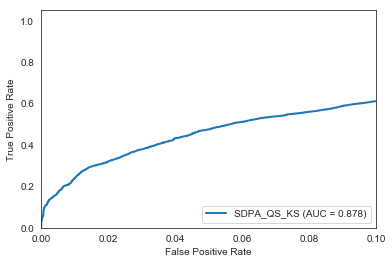

In [32]:
plot_roc_curve(y_test, y_test_prob, path_prefix, model_name=ATTENTION_NAME, max_fp=0.1)

Confusion matrix, without normalization
Normalized confusion matrix


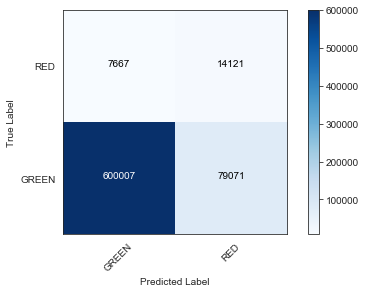

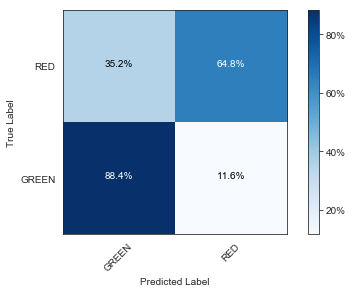

In [33]:
compute_confusion_matrix(y_test, y_test_prediction, class_names, path_prefix)

### Over test_comb - based on 'combined' labels

In [34]:
y_test_comb_prediction, y_test_comb_prob = get_model_pred_prob(model, x_test_comb, u_test_comb, val_batch_size, USE_SOURCES)
print(len(y_test_comb_prediction), len(y_test_comb))

702383/702383 [==============================] - 275s 392us/step
702383 702383


In [35]:
print_evaluation_metrics(y_test_comb, y_test_comb_prediction, y_test_comb_prob, ATTENTION_NAME)

accuracy_score for SDPA_QS_KS 0.8675722504673377
FA for SDPA_QS_KS 0.11416467700045652
Detection rate i.e. recall_score for SDPA_QS_KS 0.5123733550716199
AUC for SDPA_QS_KS 0.8073179091503718
TPR@FPR=0.001 for SDPA_QS_KS (0.0009984506799793425, 0.07916035868172819)
TPR@FPR=0.01 for SDPA_QS_KS (0.009997979147799142, 0.17884592989402584)
TPR@FPR=0.1 for SDPA_QS_KS (0.09999925153622191, 0.48538488412716896)


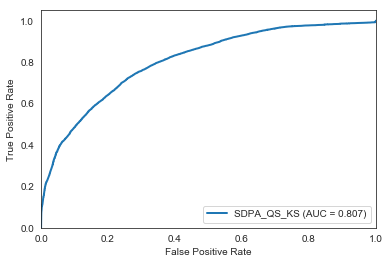

In [36]:
plot_roc_curve(y_test_comb, y_test_comb_prob, path_prefix + '_comb', model_name=ATTENTION_NAME, max_fp=1)

Confusion matrix, without normalization
Normalized confusion matrix


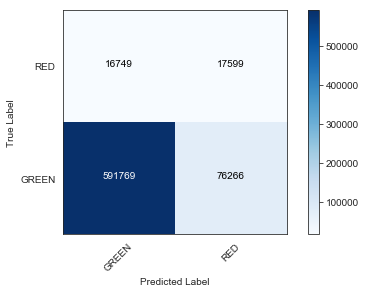

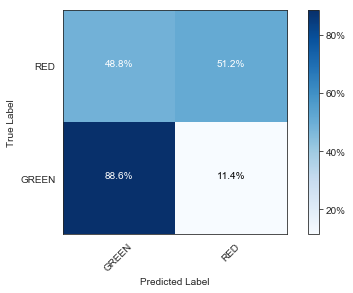

In [37]:
compute_confusion_matrix(y_test_comb, y_test_comb_prediction, class_names, path_prefix + "_comb")

# Visualize Model

In [38]:
from model_visualization_utils import *

## Print Source Embeddings

i.e. the confidence score for each source

In [39]:
if USE_SOURCES:
    print({ipsource_dict[i]: score for i, score in enumerate(get_source_embeddings(model)) if i > 0})

{'M': 0.47681683, 'R': 0.47769603, 'A': 0.60367054, 'X': 0.52995014}


## Get a sample

In [40]:
c_index = np.where(y_test==1)[0][10]
print(c_index)
print(y_test[c_index], y_test_prediction[c_index][0])

297
1 1


## Visualize Attention

In [41]:
attention_vec_out, sources_out = get_attention_sources_vecs(x_test[c_index:c_index+2], u_test[c_index:c_index+2], model,
                                                                use_sources=USE_SOURCES, attention_name=ATTENTION_NAME)
attention_vec_out = attention_vec_out[0]
print(attention_vec_out.shape)
if sources_out is not None:
    sources_out = sources_out[0]
    print(sources_out.shape)
else:
    sources_out = None

(40, 40)
(40, 32)


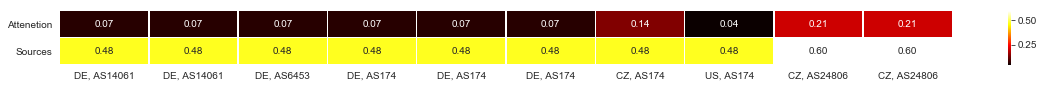

In [42]:
generate_attention_plot(c_index, test, attention_vec_out, use_sources=USE_SOURCES, sources_out=sources_out,
                        attention_name=ATTENTION_NAME)

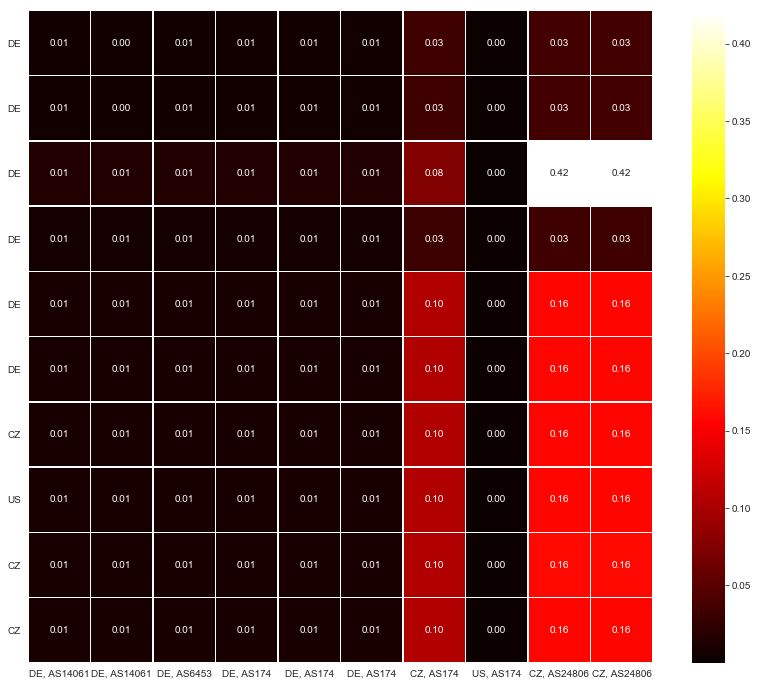

In [43]:
generate_attention_plot(c_index, test, attention_vec_out, use_sources=USE_SOURCES, sources_out=sources_out, attention_name=ATTENTION_NAME, 
                        full_attention_matrix=True, )

# Export the model to a file

In [44]:
model_json = model.to_json()
with open(MODELS_PATH + MODEL_NAME + '.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(MODELS_PATH + MODEL_NAME + '.h5')
print("Save Model")

Save Model
